# Potential Service

***Potential Service:*** The sum of greenspace area that intersects a 300 m buffer - using a moving window approach. 

For this notebook to run successfully, you will need the following **inputs**:
- `Vector` file of greenspaces. 
- `Raster` file with the desired extent and resolution (e.g., 10m resolutions raster the extent of Luton). This is your reference raster.

If we want to do distance decay:
- `Raster` file with distance to greenspace, scaled from `0-1`. Where `0` represents the location of greenspaces and `1` represents > 300m away

 --- 

### Read in packages, libraries, and data

In [2]:
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio import features
from rasterio.plot import show
from rasterio import plot
import matplotlib.pyplot as plt
import numpy as np
import time
import math

In [3]:
# Read in the vector data (OGS) and reference raster 
OGS = gpd.read_file("P:/NERC_07901_DEFRAG 2021/GIS/DO/Data/All/GSpace/GS_3km_from_build_sites.gpkg")
Ref_Ras = rasterio.open("P:/NERC_07901_DEFRAG 2021/GIS/DO/Data/All/Raster/reference_raster_gspaces_3km_from_built_sites.tif")

### Prepare the data

In [4]:
# Calculate the area for OGS in hectares
OGS['Area'] = OGS["geometry"].area*0.0001

In [5]:
# Check to see if there are any duplicates
OGS["Area"].duplicated().any()

False

In [6]:
# Create index column for unique identifier in next step
OGS['park_dissolved_id'] = OGS.index+1

If we have duplicates, we simply select the rows, and then add the park id (multiplied by a value such as 0.0000001 so that it's a small number), so that the park areas are no longer duplicates.

In [7]:
# Select rows which have duplicated area. Replace these values with the Area, multiplied by the unique park id (x 0.0000001)
OGS.loc[OGS.Area.duplicated(keep=False) == True, 'Area'] = OGS['Area']+(OGS['park_dissolved_id']*0.0000001)

In [8]:
# Going to log transform park area - to avoid having negative values, adding 1 ha to each of the park areas
OGS["Area_adapt"] = OGS["Area"]+1
OGS["Area_log"] = np.log(OGS["Area_adapt"])

In [9]:
# Define the geometry and value (greenspace area) for each cell
geom_value = ((geom,value) for geom, value in zip(OGS.geometry, OGS['Area_log']))

# Rasterize the OGS layer and attribute the value of each cell to the greenspace area (if any)
OGS_Rast1 = features.rasterize(geom_value, out_shape=Ref_Ras.shape, transform=Ref_Ras.transform, fill=0)

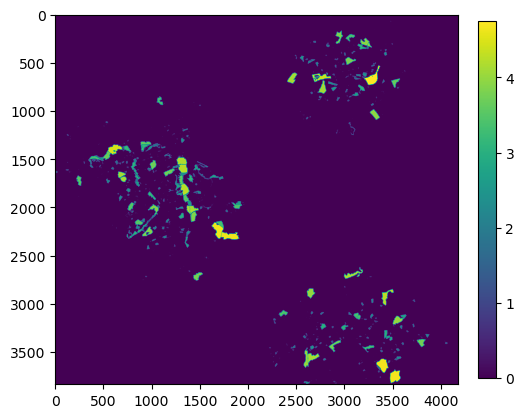

In [18]:
# Plot the raster - Note that the axes limits are incorrect - we will update this when saving the file

# Set up the figure and axes
f, ax = plt.subplots(1)
# Plot the raster
plot_x = plt.imshow(OGS_Rast1)
# Add a legend
f.colorbar(plot_x, fraction=0.036, pad=0.04);

### Create a Gauss distribution weights matrix

In [20]:
# sigma(standard deviation) and muu(mean) are the parameters of gaussian
def gauss_kernel(kernel_size, sigma=10, muu=0):
 
    # Initializing value of x,y as grid of kernel size
    # in the range of kernel size
    x, y = np.meshgrid(np.linspace(-(kernel_size - 1) / 2., 
                                    (kernel_size - 1) / 2., 
                                     kernel_size),
                       np.linspace(-(kernel_size - 1) / 2., 
                                    (kernel_size - 1) / 2., 
                                     kernel_size),)

    dst = np.sqrt(x**2+y**2)
 
    # lower normal part of gaussian
    normal = 1/(2.0 * np.pi * sigma**2)
    # Calculating Gaussian filter
    gauss = np.exp(-((dst-muu)**2 / (2.0 * sigma**2))) * normal
    
    return gauss 

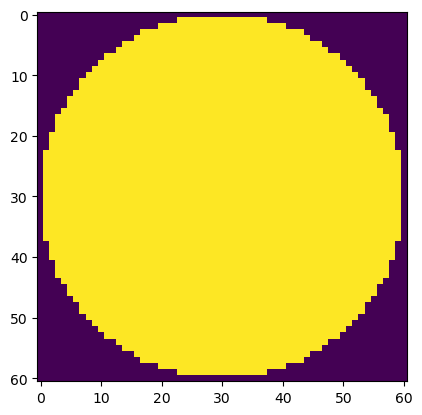

In [22]:
# Calculate matrix with kernel size of 61 (300m radius)
W = gauss_kernel(61)

# Make it circular by enforcing top central value as max and setting anything else to 0
Thr = W[0, 30]
W[W<Thr] = Thr
W=W-Thr
W=W/np.max(W) # change the weightings to simple 0-1 proportional, base on max value

# Now we have the circular focal matrix, change all positive values to 1
fix_val = 1
W[W>0] = fix_val

# Plot
show(W);

### Calculate the sum of greenspace areas that intersect with 300m buffer

In [24]:
%%time
# Define the custom function that applies that sums the unique values (area) within the 300m buffer (W)
def weighted_unique_sum(window, W):
    # Apply the weights
    weighted_window = window[W == 1]
    # Calculate the sum of unique values
    return np.sum(np.unique(weighted_window))

# Pad the input data to handle borders
pad_width = W.shape[0] // 2
padded_data = np.pad(OGS_Rast1, pad_width, mode='constant', constant_values=0)

# Initialize the result array
result = np.zeros_like(OGS_Rast1)

# Iterate over the input data
for i in range(result.shape[0]):
    for j in range(result.shape[1]):
        # Extract the window around the current cell
        window = padded_data[i:i + W.shape[0], j:j + W.shape[1]]
        # Apply the custom function to the window
        result[i, j] = weighted_unique_sum(window, W)

CPU times: total: 6min 59s
Wall time: 9min 19s


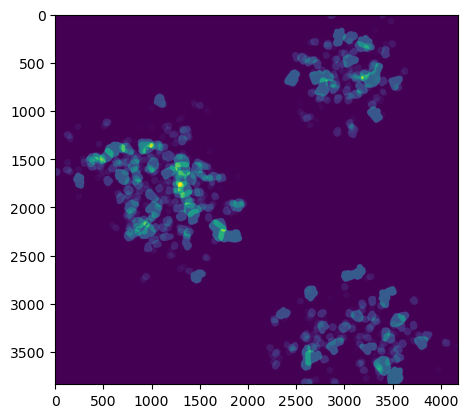

In [25]:
show(result);

### Save File

In [42]:
# Save this distance decay as new raster file as it is currently a numpy array.
# We will want to save the file and assign it coordinates and a crs. Easiest way to do this is to use a reference raster layer 

# Copy the profile of Reference raster layer (e.g. CRS, extent, etc.)
profile_ref = Ref_Ras.profile

# Write the file
with rasterio.open("potential_service.tif", 'w', **profile_ref) as dst:
     dst.write(result, 1)

# End
---
### Multiply the sum of greenspace area within 300m with distance decay

To avoid having sharp cut-off points, we want to create a distance decay. To do this, we use another raster layer, which represents the distance to greenspace. This layer is scaled from 0-1, where 0 represents parks and 1 represents distances greater than 300m. 

The output we want is that cells closer to these greenspaces retain their original value, whereas values nearing 300m from the park slowly decrease, eventually equal to 0 when beyond 300m.  

To do this, we use the following equation:  
  
$ Access\;to\;Greenspace\;with\;Distance\;Decay = \sum GreenSpace\;Area\; \times (1 - Distance\;to\;Greenspace\;Scaled) $

In [27]:
# Read in the data - scaled distance to greenspace
#dist_to_gspace_scaled = rasterio.open("P:/NERC_07901_DEFRAG 2021/GIS/DO/Data/Luton/R_scripts/data_GIS/gspace_dist_scaled_0_1_new_extent.tif")
#dist_to_gspace_scaled = dist_to_gspace_scaled.read(1)
#dist_to_gspace_scaled

In [28]:
# Multiply each cell's sum of unique greenspace areas with the distance decay  
#gspace_dist_decay = result * (1-dist_to_gspace_scaled)

In [29]:
#show(gspace_dist_decay);